In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from helper import finalize_plot

sns.set_theme()
sns.set_context("paper", font_scale=1.50)
sns.set_style('ticks', {'font.family': 'Times New Roman'})

## Draft VISIR Histograms 

These histograms are great at displaying the distribution of our VISIR dataset. Subsetting the data by molecule availability allow us to see the gaps in our flux measurements in comparison to the disk properties like mass, luminosity, and temperature.

Goals for the histograms:
- Find gaps in flux line measurements and their disk property distributions
- Inform data completeness, and biases

In [2]:
visir = pd.read_csv('../Data/VISIR_merged_fluxes_TMP.csv', skipinitialspace=True, 
                    na_values=['#NAME?']).rename({'n_13-30':'n_13_30'}, axis='columns')

In [3]:
x_visir = ['Mstar', 'Lstar', 'Teff', 'logLacc', 'n_13_30', 'incl']
visir_log = ['Mstar', 'Lstar', 'Teff']

## Histogram Input

To make my life easier, I decide to use the seaborn package, and their built-in categorical label creation. However, this function does not allow duplicates, and each data row must have a mutually exclusive labels (1 single label). In our case however each data row can have up to two mutually inclusive labels:

1. Water flux data available
2. Neon flux data available

there is a third label that is mutually exclusive to the other two, and therefore does not cause problems: 
- Missing flux data 

In order to use the seaborn package we must force duplicates, and treat each duplicate as an indepedent data row. Then store the result in a DataFrame:

In [4]:
# Get Dictionary ready
hist_data = dict(labels=[])
for prop in x_visir:
    hist_data[f'{prop}'] = []
    
for row in visir.itertuples():
    if not np.isnan(row.flux_x):
        hist_data['labels'].append('H$_2$O')
        for prop in x_visir:
            hist_data[f'{prop}'].append(getattr(row, prop))
    
    if not np.isnan(row.flux_y):
        hist_data['labels'].append('Neon[II]')
        for prop in x_visir:
            hist_data[f'{prop}'].append(getattr(row, prop))
    
    if np.isnan(row.flux_x) and np.isnan(row.flux_y):
        hist_data['labels'].append('Missing')
        for prop in x_visir:
            hist_data[f'{prop}'].append(getattr(row, prop))

hist_data = pd.DataFrame(data=hist_data)
hist_data

,labels,Mstar,Lstar,Teff,logLacc,n_13_30,incl
0,H$_2$O,NaN,NaN,NaN,NaN,-1.080330,NaN
1,H$_2$O,4.20,312.00,10250.0,NaN,NaN,63.0
2,H$_2$O,0.87,2.14,4210.0,-0.07,-0.190620,20.0
3,H$_2$O,0.96,0.87,4210.0,-1.12,-0.281149,35.0
4,H$_2$O,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
81,Neon[II],0.72,0.83,NaN,-2.51,-0.057410,43.1
82,Missing,1.22,0.93,4540.0,-0.73,0.807352,34.0
83,Missing,1.50,6.60,7750.0,-0.10,NaN,32.0
84,Missing,1.70,7.60,7500.0,NaN,NaN,23.0


As we can see we end up with 86 data rows, instead of the original 65 VISIR data rows. This tells us there is 21 duplicates (targets with both water and neon data).

## Histogram Visualization

To visualize each disk property distribution we create a grid of plots, and iterate over each disk property, and let seaborn label and color the subsets. Because of the way we designed the histogram input, the area under the histogram does not equal the VISIR dataset length, instead it will equal to 86 counts. 

For now we will use the `rice` method for bin estimation; this may change in the future.

Each subplot is designed to showcase the distribution of each flux data availability subsample. Furthermore, I thought it was a good idea to inform the disk property data completeness on the title. For example, the Mstar disk property is 74% complete for our dataset, meaning 26% of the VISIR dataset are missing Mstar measurements.

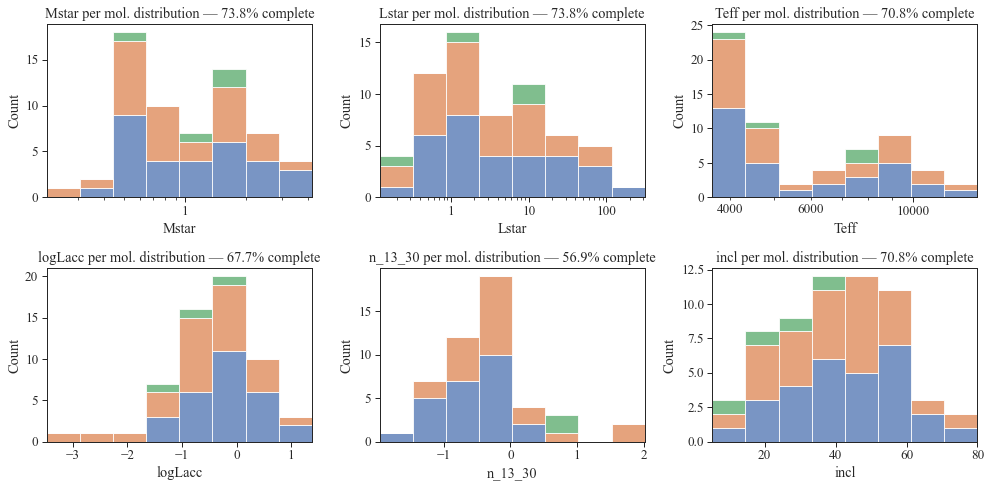

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 7))
data_length = visir.shape[0]
bins_method = 'rice'

log_scale=False
for prop, ax in zip(x_visir, axes.flat):
    log_scale = prop in visir_log
    completeness = 100 * visir[prop].count() / data_length
    sns.histplot(data=hist_data, x=prop, hue='labels', hue_order=['Missing', 'Neon[II]', 'H$_2$O'], 
                 bins=bins_method, kde=False, stat='count', palette=reversed(sns.color_palette(n_colors=3)),
                 multiple='stack', log_scale=log_scale, legend=False, ax=ax)
    
    title = f'{prop} per mol. distribution — {completeness:.1f}% complete'
    finalize_plot(ax, log=log_scale, xlabel=f'{prop}', title=title)

plt.tight_layout()

## Notes — Findings

Blue: water flux data \
Orange: Neon flux data \
Green: missing flux data

- Lacking flux measurements for very low mass stars
- Lacking Neon measurements for high luminosity stars (same for mass)
- More measurements for colder than the Sun stars
- Lacking measurements (especially water) for low Lacc; data incompleteness?
- Lack of measurements for positive n_13-30; but could be associated to data incompleteness
- Gaussian-like distribution centered at 40-50 deg